# Face Classifier using Keras Sequential API

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras

print("Versão do TensorFlow:", tf.__version__)
print("Versão do Keras:", keras.__version__)
print("Versão do Scikit-learn:", sklearn.__version__)

Versão do TensorFlow: 2.19.0
Versão do Keras: 3.9.2
Versão do Scikit-learn: 1.6.1


---
## 1. Carregar e Pré-processar a Base de Dados

Inicialmente, tentei com o datasete LFW, entretanto, devido a ser muito desbalanceado (muitas imagens de apenas uma classe) e despadronizado (rostos em muitas posições diferentes), o modelo não conseguiu aprender nada.

In [17]:
# # --- 1. Carregar e Pré-processar a Base de Dados (LFW People) ---
# print("Carregando a base de dados LFW People...")

# # Vamos buscar pessoas que tenham pelo menos 70 fotos na base LFW
# # Isso nos dará um número razoável de classes e exemplos por classe
# # resize=0.4 reduz a dimensionalidade para acelerar o treinamento
# lfw_people = sklearn.datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# # Inspecionar os dados carregados
# n_samples, h, w = lfw_people.images.shape
# X = lfw_people.data # Dados como vetores planos (n_samples, n_features)
# y = lfw_people.target # Rótulos (índices das pessoas)
# target_names = lfw_people.target_names # Nomes das pessoas (classes)
# n_classes = target_names.shape[0]
# n_features = X.shape[1] # Número de pixels após o flatten

# print(f"\n--- Informações da Base de Dados ---")
# print(f"Número total de amostras: {n_samples}")
# print(f"Número de classes (pessoas com >= 70 fotos): {n_classes}")
# print(f"Nomes das classes: {', '.join(target_names)}")
# print(f"Dimensões das imagens originais (após resize): {h} x {w}")
# print(f"Número de features (pixels por imagem): {n_features}")

# # Pré-processamento:
# # 1. Normalizar os pixels para o intervalo [0, 1]
# X = X / 255.0

# # 2. Remodelar para o formato esperado pela CNN (samples, height, width, channels)
# # Como as imagens são em escala de cinza, o número de canais é 1.
# X_images = X.reshape((n_samples, h, w, 1))
# input_shape = (h, w, 1)

# # 3. Dividir em conjuntos de treino e teste
# # stratify=y garante que a proporção de cada classe seja mantida nos conjuntos
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
#     X_images, y, test_size=0.25, random_state=42, stratify=y
# )

# print(f"\n--- Divisão dos Dados ---")
# print(f"Formato X_train: {X_train.shape}")
# print(f"Formato X_test: {X_test.shape}")
# print(f"Formato y_train: {y_train.shape}")
# print(f"Formato y_test: {y_test.shape}")

Carregando a base de dados LFW People...

--- Informações da Base de Dados ---
Número total de amostras: 1288
Número de classes (pessoas com >= 70 fotos): 7
Nomes das classes: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair
Dimensões das imagens originais (após resize): 50 x 37
Número de features (pixels por imagem): 1850

--- Divisão dos Dados ---
Formato X_train: (966, 50, 37, 1)
Formato X_test: (322, 50, 37, 1)
Formato y_train: (966,)
Formato y_test: (322,)


Em seguida, utilizei o dataset Olivetti Faces, que possui classes balanceadas e padronização. (40 classes com 10 imagens cada, sendo rostos de frente centralizados)

In [3]:
# --- 1. Carregar e Pré-processar a Base de Dados (Olivetti Faces) ---
print("Carregando a base de dados Olivetti Faces...")
faces = sklearn.datasets.fetch_olivetti_faces()

# Inspecionar os dados
n_samples, h, w = faces.images.shape
X = faces.data # Já vem como vetores planos, mas podemos usar faces.images
y = faces.target # Rótulos (0 a 39)
n_classes = len(np.unique(y)) # 40
target_names = [f"Pessoa {i}" for i in range(n_classes)] # Nomes genéricos

print(f"\n--- Informações da Base de Dados Olivetti ---")
print(f"Número total de amostras: {n_samples}") # 400
print(f"Número de classes: {n_classes}")      # 40
print(f"Dimensões das imagens: {h} x {w}")     # 64x64

# Verificar balanceamento (deve ser 10 por classe)
classes, counts = np.unique(y, return_counts=True)
print("Distribuição das classes:", dict(zip(classes, counts)))

Carregando a base de dados Olivetti Faces...

--- Informações da Base de Dados Olivetti ---
Número total de amostras: 400
Número de classes: 40
Dimensões das imagens: 64 x 64
Distribuição das classes: {np.int64(0): np.int64(10), np.int64(1): np.int64(10), np.int64(2): np.int64(10), np.int64(3): np.int64(10), np.int64(4): np.int64(10), np.int64(5): np.int64(10), np.int64(6): np.int64(10), np.int64(7): np.int64(10), np.int64(8): np.int64(10), np.int64(9): np.int64(10), np.int64(10): np.int64(10), np.int64(11): np.int64(10), np.int64(12): np.int64(10), np.int64(13): np.int64(10), np.int64(14): np.int64(10), np.int64(15): np.int64(10), np.int64(16): np.int64(10), np.int64(17): np.int64(10), np.int64(18): np.int64(10), np.int64(19): np.int64(10), np.int64(20): np.int64(10), np.int64(21): np.int64(10), np.int64(22): np.int64(10), np.int64(23): np.int64(10), np.int64(24): np.int64(10), np.int64(25): np.int64(10), np.int64(26): np.int64(10), np.int64(27): np.int64(10), np.int64(28): np.int64(1

In [4]:
# Pré-processamento:
# 1. Normalizar os pixels para o intervalo [0, 1]
X_images = faces.images #/ 255.0 (O dataset já veio normalizado, portanto não precisamos dividir por 255.0)

# 2. Remodelar para o formato esperado pela CNN (samples, height, width, channels)
# Como as imagens são em escala de cinza, o número de canais é 1.
X_images = X_images.reshape((n_samples, h, w, 1))
input_shape = (h, w, 1)

# 3. Dividir em conjuntos de treino e teste
# stratify=y garante que a proporção de cada classe seja mantida nos conjuntos
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_images, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n--- Divisão dos Dados ---")
print(f"Formato X_train: {X_train.shape}")
print(f"Formato X_test: {X_test.shape}")
print(f"Formato y_train: {y_train.shape}")
print(f"Formato y_test: {y_test.shape}")


--- Divisão dos Dados ---
Formato X_train: (320, 64, 64, 1)
Formato X_test: (80, 64, 64, 1)
Formato y_train: (320,)
Formato y_test: (80,)


---
## 2. Construir o Modelo CNN usando a Sequential API

In [5]:
# Inspirado na arquitetura LeNet-5, adaptada para o tamanho da imagem

print("\nConstruindo o modelo CNN...")

model = keras.models.Sequential([
    # Camada de Convolução 1: Extrai features iniciais
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'), # 32 filtros de 3x3, com padding 'same', ou seja, a imagem de saída terá o mesmo tamanho que a entrada
    keras.layers.MaxPooling2D(pool_size=(2, 2)), # Reduz a dimensionalidade pela metade (2x2)
    keras.layers.Dropout(0.25), # Dropout para evitar overfitting

    # Camada de Convolução 2: Extrai features mais complexas
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Camada de Convolução 3 (Opcional, pode ajudar)
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # Achatamento: Transforma o mapa de features 2D em um vetor 1D
    keras.layers.Flatten(),

    # Camada Densa (Totalmente Conectada) 1: Combina as features extraídas
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5), # Dropout mais forte antes da camada final

    # Camada de Saída:
    # - Neurônios: n_classes (um para cada pessoa)
    # - Ativação: 'softmax' para obter probabilidades por classe
    keras.layers.Dense(n_classes, activation='softmax')
])


Construindo o modelo CNN...


d:\GitHub Projects\hands-on-ml-face-recognition\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---
## 3. Compilar o Modelo

In [ ]:
# - Otimizador: Adam é uma escolha robusta e comum.
# - Função de Perda: 'sparse_categorical_crossentropy' é adequada quando os rótulos
#   são inteiros (como em nosso caso, 0, 1, 2...) e a saída tem ativação softmax.
#   Se os rótulos fossem one-hot encoded, usaríamos 'categorical_crossentropy'.
# - Métricas: 'accuracy' para monitorar a performance durante o treino.

print("Compilando o modelo...")
model.compile(loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy é adequada para rótulos inteiros
              # categorical_crossentropy é adequada para rótulos one-hot encoded
              optimizer=keras.optimizers.Adam(learning_rate=0.001), # learning_rate=0.001 é o padrão
              metrics=['accuracy']) # Monitorar a acurácia durante o treinamento
                       
# Exibir um resumo da arquitetura do modelo
model.summary()

Compilando o modelo...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,146,536 (4.37 MB)

 Trainable params: 1,146,536 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Pesos foram implementados na tentativa de corrigir o debalanceamento do dataset LFW, o que não foi suficiente.
# No dataset Olivetti, não há necessidade de pesos, pois o dataset já é balanceado, mas o código foi mantido pois não afeta o treinamento.
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Precisa converter para um dicionário esperado pelo Keras
class_weights_dict = dict(enumerate(class_weights))
print("\nPesos das Classes:", class_weights_dict)


Pesos das Classes: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0), 16: np.float64(1.0), 17: np.float64(1.0), 18: np.float64(1.0), 19: np.float64(1.0), 20: np.float64(1.0), 21: np.float64(1.0), 22: np.float64(1.0), 23: np.float64(1.0), 24: np.float64(1.0), 25: np.float64(1.0), 26: np.float64(1.0), 27: np.float64(1.0), 28: np.float64(1.0), 29: np.float64(1.0), 30: np.float64(1.0), 31: np.float64(1.0), 32: np.float64(1.0), 33: np.float64(1.0), 34: np.float64(1.0), 35: np.float64(1.0), 36: np.float64(1.0), 37: np.float64(1.0), 38: np.float64(1.0), 39: np.float64(1.0)}


---
## 4. Treinar o Modelo

In [9]:
print("\nIniciando o treinamento...")
epochs = 100 # Número de épocas (pode precisar de ajuste)
batch_size = 32 # Tamanho do lote

# Definindo o callback de Early Stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitorar a perda de validação
    patience=10, # Número de épocas sem melhoria antes de parar
    restore_best_weights=True, # Restaurar os melhores pesos ao final do treinamento
    )

# Usamos o conjunto de teste como validação para monitorar o overfitting
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    class_weight=class_weights_dict,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

print("Treinamento concluído.")


Iniciando o treinamento...
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.0069 - loss: 3.7706 - sparse_categorical_accuracy: 0.0069 - val_accuracy: 0.0250 - val_loss: 3.6885 - val_sparse_categorical_accuracy: 0.0250
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.0275 - loss: 3.6905 - sparse_categorical_accuracy: 0.0275 - val_accuracy: 0.0250 - val_loss: 3.6886 - val_sparse_categorical_accuracy: 0.0250
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.0211 - loss: 3.6867 - sparse_categorical_accuracy: 0.0211 - val_accuracy: 0.0250 - val_loss: 3.6883 - val_sparse_categorical_accuracy: 0.0250
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.0129 - loss: 3.6938 - sparse_categorical_accuracy: 0.0129 - val_accuracy: 0.0250 - val_loss: 3.6883 - val_sparse_categorical_accuracy: 0.0250
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.0203 - loss: 3.6905 - sparse_categorical_accuracy: 0.0203 - val_accurac

---
## 5. Avaliar o Modelo

In [10]:
print("\nAvaliando o modelo no conjunto de teste...")
loss, accuracy, sparse_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Perda no teste (Test Loss): {loss:.4f}")
print(f"Acurácia no teste (Test Accuracy): {100*accuracy:.2f}%; {100*sparse_accuracy:.2f}%")


Avaliando o modelo no conjunto de teste...
Perda no teste (Test Loss): 0.1529
Acurácia no teste (Test Accuracy): 93.75%; 93.75%


---
## 6. Visualizar o Histórico de Treinamento

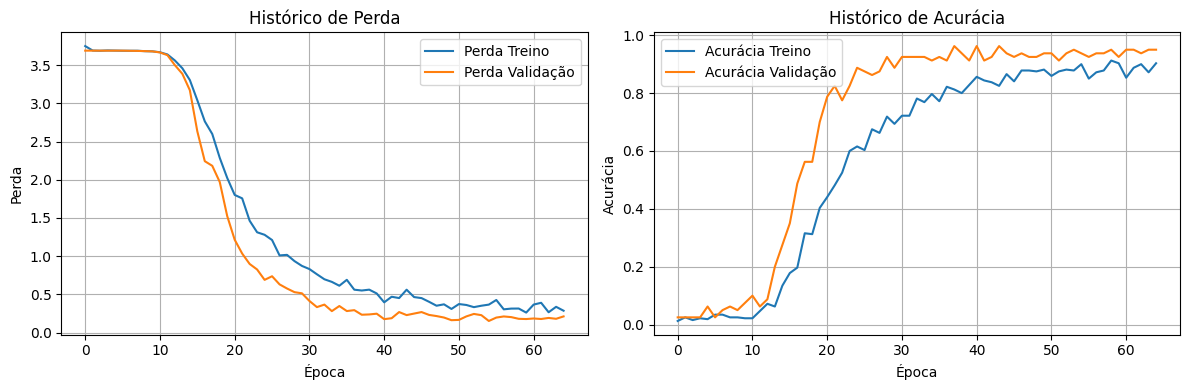

In [11]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title('Histórico de Perda')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Histórico de Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

---
## 7. Fazer Previsões e Mostrar Probabilidades


Fazendo previsões em algumas imagens do conjunto de teste...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

--- Probabilidades para a Imagem 1 (Verdadeiro: Pessoa 21) ---
  Classe 'Pessoa 21': 0.9986
------------------------------

--- Probabilidades para a Imagem 2 (Verdadeiro: Pessoa 16) ---
  Classe 'Pessoa 16': 0.9875
------------------------------

--- Probabilidades para a Imagem 3 (Verdadeiro: Pessoa 15) ---
  Classe 'Pessoa 15': 0.9852
------------------------------

--- Probabilidades para a Imagem 4 (Verdadeiro: Pessoa 34) ---
  Classe 'Pessoa 34': 0.9985
------------------------------

--- Probabilidades para a Imagem 5 (Verdadeiro: Pessoa 37) ---
  Classe 'Pessoa 37': 0.9991
------------------------------


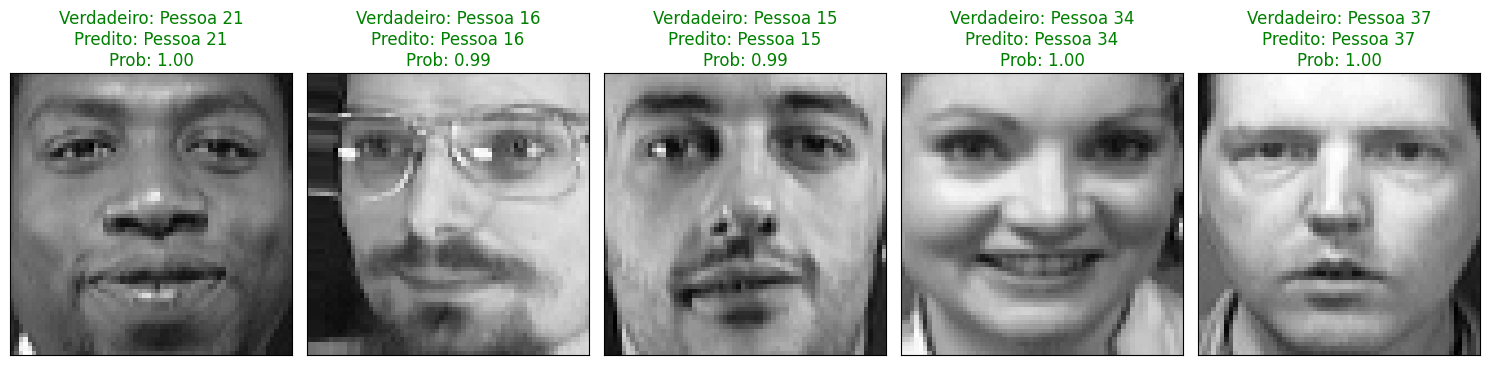


Execução concluída.


In [12]:
print("\nFazendo previsões em algumas imagens do conjunto de teste...")

# Selecionar algumas imagens aleatórias do conjunto de teste
n_predictions = 5
random_indices = np.random.choice(X_test.shape[0], size=n_predictions, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]

# Fazer as previsões (o método predict retorna as probabilidades)
predictions_proba = model.predict(sample_images)

# Obter a classe predita (o índice com a maior probabilidade)
predictions_class = np.argmax(predictions_proba, axis=1)

# Mostrar os resultados
plt.figure(figsize=(15, 5))
for i in range(n_predictions):
    plt.subplot(1, n_predictions, i + 1)
    # Remodelar a imagem de volta para (h, w) para exibição
    plt.imshow(sample_images[i].reshape(h, w), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])

    true_label = target_names[sample_labels[i]]
    predicted_label = target_names[predictions_class[i]]
    predicted_prob = predictions_proba[i][predictions_class[i]] # Probabilidade da classe predita

    title_color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"Verdadeiro: {true_label}\nPredito: {predicted_label}\nProb: {predicted_prob:.2f}", color=title_color)

    # Imprimir todas as probabilidades para cada imagem
    # if i == 0:
    print(f"\n--- Probabilidades para a Imagem {i+1} (Verdadeiro: {true_label}) ---")
    for j, prob in enumerate(predictions_proba[i]):
          # Mostrar apenas as probabilidades mais relevantes (ex: > 1%)
          if prob > 0.01:
            print(f"  Classe '{target_names[j]}': {prob:.4f}")
    print("-" * 30)


plt.tight_layout()
plt.show()

print("\nExecução concluída.")